# Load in Data
Using the MNE data set, slightly modified to pretend that the button presses were in response to the stimuli (in this example the subject went 16/304 on responses to stimuli so they weren't paying much attention :) ), a model for how to use this tool to preprocess and do preliminary analyses on a complex task including stimuli and a response is presented

In [3]:
if True:
    from MEEGbuddy import MEEGbuddy
    '''Please read import errors and warnings and if there
       are packages that are useful for your analyses you can'''
    from pandas import read_csv, DataFrame
    from shutil import copyfile
    import mne, os
    import os.path as op
    import numpy as np
    #
    subject = 'sample'
    #
    task = 'AudioVis'
    #
    stimuli = {'Cue':['STI 014',-0.5,1]}
    response = ['STI 006',-1.5,1]
    baseline = ['STI 014',-1.1,-0.1]
    #
    sample_mne_data_path = mne.datasets.sample.data_path(path=op.join(os.getcwd(),'data'))
    behavior = op.join(sample_mne_data_path, 'MEG', 'sample', 'sample_audvis.csv')
    fdata = op.join(sample_mne_data_path, 'MEG', 'sample', 'sample_audvis-raw.fif')
    fdata2 = op.join(sample_mne_data_path, 'MEG', 'sample', 'sample_audvis_raw.fif')
    stim_key = {1:'Left Auditory',2:'Left Visual',3:'Right Auditory',4:'Right Visual',
                5:'Smiley'}
    #
    fs_subjects_dir = op.join(sample_mne_data_path,'subjects')
    bemf = op.join(fs_subjects_dir,'%s/bem/sample-5120-5120-5120-bem-sol.fif' %(subject))
    srcf = op.join(fs_subjects_dir,'%s/src/sample-ico-5-src.fif' %(subject))
    transf = op.join(sample_mne_data_path, 'MEG', subject,'sample_audvis_raw-trans.fif')
    #
    if not op.isfile(behavior) or not op.isfile(fdata):
        raw = mne.io.Raw(fdata2,preload=True)
        events = mne.find_events(raw,stim_channel='STI 014')
        events_button = mne.find_events(raw,stim_channel='STI 006')
        for event in (events_button[:,0]-raw.first_samp):
            raw._data[raw.info['ch_names'].index('STI 014'),event:event+10] = 0 #take responses out of this channel
        events_no_button = events[events[:,2] != 32]
        events_button = events[events[:,2] == 32]
        response_times = []  
        '''pretend buttons are in response to last stimulus shown 
        i.e. the subject was told to respond to all stimuli but only did so for a few 
        (not realistic but just to model for other tasks)'''
        for i,(t,_,event_id) in enumerate(events[:-1]):
            if events[i+1,2] == 32:
                response_times.append((events[i+1,0]-events[i,0])/raw.info['sfreq'])
            elif events[i,2] != 32:
                response_times.append(np.nan)
        behavior_data = {'Trial':np.arange(len(events_no_button)),
                         'Stimulus Type':np.array([stim_key[e] for e in events_no_button[:,2]]),
                         'Response Time':response_times}
        df = DataFrame(behavior_data)
        df.to_csv(behavior)
        raw.save(fdata,overwrite=True)
    if not op.isfile(bemf):
        conductivity = (0.3, 0.006, 0.3)  # for three layers
        model = mne.make_bem_model(subject='sample', ico=4,
                                   conductivity=conductivity,
                                   subjects_dir=fs_subjects_dir)
        bem = mne.make_bem_solution(model)
        mne.write_bem_solution(bemf,bem)
    if not op.isfile(op.join(fs_subjects_dir,srcf)):
        src = mne.setup_source_space('sample', spacing='oct6',
                                     subjects_dir=fs_subjects_dir, add_dist=False)
        src.save(srcf,overwrite=True)
    df = read_csv(behavior)
    no_response = [i for i,rt in enumerate(df['Response Time']) if np.isnan(rt)]
    exclude_response = [0,len(df)-1]
    print('Loading into MEEGbuddy ' + subject)
    data = MEEGbuddy(subject=subject,session='1',fdata=fdata,behavior=behavior,baseline=baseline,
                     stimuli=stimuli,meg=True,eeg=True,response=response,no_response=no_response,
                     task=task,exclude_response=exclude_response,fs_subjects_dir=fs_subjects_dir,
                     bemf=bemf,srcf=srcf,transf=transf,subjects_dir=op.join(os.getcwd(),'data'))


Loading into MEEGbuddy sample


# Preprocessing

## Filter Raw Data
Remove DC offset and very low frequency components for visualization.
MEEGbuddy works on the basic system of naming data with keywords,
in this case no keyword loads the raw data file and then keyword_out
saves the data elsewhere (it's impossible to overwrite the original).
My suggestion is to save out many copies at first when you're designing
your analysis but then to save out just the crutial ones when you're 
analyzing many subjects to save space.
Usually people don't analyze this low so we can just apply this to the raw
data without using a keyword argument to save a new branch as a copy.
Note: if you are getting weird results with the ICA in MEG it is probably because
the cHPI coil signal has not been filtered out. This is at approximately 150 Hz
so a 130 or lower lowpass is usually needed.

In [2]:
from MEEGbuddy import loadMEEGbuddies
import os.path as op
import os

data = loadMEEGbuddies(op.join(os.getcwd(),'data'))[0]

data.filterRaw(keyword_out='Preprocessed',maxwell=True,overwrite=True)
data.filterRaw(keyword_in='Preprocessed',l_freq=0.1,overwrite=True) # if no keyword_out, keyword_in gets used

/autofs/space/karima_001/users/alex/MEEGbuddy/MEEGbuddyDemo/data/MNE-sample-data/MEG/sample/sample_audvis-raw.fif
Saving raw Preprocessed
Preprocessed raw data loaded.
Saving raw Preprocessed


## Mark Bads

Use the automatic bad channel marker algorithm

In [3]:
from MEEGbuddy import loadMEEGbuddies
import os.path as op
import os

data = loadMEEGbuddies(op.join(os.getcwd(),'data'))[0]
# can data_struct = load... and then for data in data_struct to process multiple subjects

data.autoMarkBads(keyword_in='Preprocessed',overwrite=True) 

Preprocessed raw data loaded.
grad
mag
eeg
EEG 053 removed: flat
Saving raw Preprocessed


## Plot Raw
QC that auto mark bads did a good enough job, we don't want really bad
components in the data because they could swamp our ICA. It's also a huge
pain to select out bad channels for many subjects, hence this very simple
approach of autoMarkBads that could potentially eliminate this step (NB: autoMarkBads is not very sensitive which is a good thing because if there is 
usable data we want to let autoreject try to save it by rejecting and interpolating epochs that need it)

In [4]:
from MEEGbuddy import loadMEEGbuddies
import os.path as op
import os

% matplotlib

data = loadMEEGbuddies(op.join(os.getcwd(),'data'))[0]

data.plotRaw(keyword='Preprocessed',overwrite=True) 

Using matplotlib backend: Qt5Agg
Preprocessed raw data loaded.
Saving raw Preprocessed


## Interpolate TMS Artifact (only for TMS, not relevant to this sample dataset)

In [ ]:
from MEEGbuddy import loadMEEGbuddies
import os.path as op
import os

event = 'Cue'

data = loadMEEGbuddies(op.join(os.getcwd(),'data'))[0]
raw_interp,_ = data.plotInterpolateArtifact(event,keyword='Preprocessed',mode='spline',npoint_art=5,offset=1,tmin=-0.1,tmax=0.1,ylim=[-1e-4,1e-4])
data.applyInterpolation(raw_interp,keyword_out='TMS')

## Make Epochs
We already supplied all the information needed to make epochs.

In [4]:
from MEEGbuddy import loadMEEGbuddies
import os.path as op
import os

data = loadMEEGbuddies(op.join(os.getcwd(),'data'))[0]

data.makeEpochs(keyword_in='Preprocessed',overwrite=True) 
# I didn't use a keyword for this one which just defaults to an empty keyword

Preprocessed raw data loaded.
Baseline events found: 304
Saving epochs for Baseline
Baseline epochs loaded
Cue events found: 304
Saving epochs for Cue
Cue epochs loaded
Response events found: 16
Saving epochs for Response


## Interpolate TMS Artifact Epochs (Again only TMS)
When analyzing TMS-EEG, it's best to process the raw into epochs and visualize things like the multitaper spectrogram to determine sleep/wake or other analyses of raw data, but the data that is used for final analysis should make epochs with raw data that has not been downsampled (you should be sampling at at least 5kHz for TMS-EEG) so that the event timing is as accurate as possible. Then, in the case of downsampling epochs, you would have to do ICA on the epochs instead of the raw data from which you cannot generate blink or saccade epochs so it is not preferable if you aren't downsampling.

In [ ]:
from MEEGbuddy import loadMEEGbuddies
import os.path as op
import os

data = loadMEEGbuddies(op.join(os.getcwd(),'data'))[0]

event = 'Cue' 

data.preload = False # use memory mapping to load in a large file that otherwise couldn't fit on RAM
data.makeEpochs(keyword_out='TMS',overwrite=True) # take in the raw, unprocessed data
data.downsample(event,keyword_out='TMS',overwrite=True) # now okay to downsample once epochs are made and events are locked in
epo_interp,_ = data.plotInterpolateArtifact(event,use_raw=False,keyword='TMS',mode='spline',npoint_art=5,offset=1,tmin=-0.1,tmax=0.1,ylim=[-6e-5,4e-5])
# it doesn't look like it did anything because there is no TMS artifact in this dataset!
data.applyInterpolation(epo_interp,event,keyword_out='TMS')
data.plotEpochs(event,keyword_in='TMS',overwrite=True) # still have to select out bad channels before ICA

## Filter Epochs
We filter data for visualization and save it out as
    a copy so as to keep unfiltered data.

In [5]:
from MEEGbuddy import loadMEEGbuddies
import os.path as op
import os

data = loadMEEGbuddies(op.join(os.getcwd(),'data'))[0]

event = 'Cue'
condition = 'Stimulus Type'
data.filterEpochs(event,h_freq=40,l_freq=None,keyword_out='40Hz_low_pass') 

Cue epochs loaded
Saving epochs for Cue 40Hz_low_pass


## Visualize Evoked
We compare conditions (Left/Right Auditory/Visual)
    that can be provided by values but if value argument
    is not passed they are selected by default as all the unique
    conditions. As you can see from the plot there is a ton of eyeblink
    contamination that ICA will hopefully remove and if not
    those epochs will be rejected (by autoreject).

In [1]:
from MEEGbuddy import loadMEEGbuddies
import os.path as op
import os

% matplotlib

data = loadMEEGbuddies(op.join(os.getcwd(),'data'))[0]

event = 'Cue'
condition = 'Stimulus Type'
data.plotEvoked(event,condition=condition,keyword='40Hz_low_pass',
                show=True,detrend=1,downsample=False) 

Cue epochs loaded for 40Hz_low_pass


/autofs/space/karima_001/users/alex/software/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


## Precompute ICA

In [1]:
from MEEGbuddy import loadMEEGbuddies
import os.path as op
import os

data = loadMEEGbuddies(op.join(os.getcwd(),'data'))[0]

data.findICA(keyword_in='Preprocessed',keyword_out='ICA', n_components=50)

Preprocessed raw data loaded.
Using EOG 061 as eogs
Using  as ecgs
grad
Saving evoked for ica_EOG 061 grad_ICA


KeyError: 'evoked'

Quality check ICA (will need to do multiple times if the components are hand-selected) (click on the component name to see topo)

    I removed components 1 (blink), 8 (heartbeat), 36 (heartbeat) for magnetometers,
    1 (sacade), 2 (heartbeat), 21 (heartbeat) for gradiometers and 0 (blink), 1 (whole head),
    7 (heartbeat), 14 (muscle), 19 (muscle), 22 (muscle), 28-32 (muscle), 34 (muscle), 36 (muscle),
    39 (muscle), 42-43 (muscle) and 45 (muscle) for eeg. These are hard without HEOG and ECG 
    accessory electrodes. There are three things that show up at first; 
    a evoked time course of each of the ICA source components for each auxillary channel,
    a topo of all the components and a time course of the ICA components raw.plot()-style
    where the components can be selected out. 
    
    The way I choose has three parts: 
    
    First, I look at the topological distributions, distributions that are front heavy 
    and look like eyes are probably blinks, distributions that have a left-right polarization
    (left red, right blue or vice versa) are probably saccades (although these are sometimes
    tricky because they have a tilt to them) and distributions that are back-heavy (occipital)
    are probably heartbeat (eeg 7 is a good example). I also see global components which 
    look like a mostly all red or all blue topo, these are usually the first one or two 
    and in my experience tend to be blinks or mixes of the artifacts. In general there are
    often one major component for each source (blinks, saccades, heartbeat) and sometimes
    a few what I like to think of as harmonics. It would be a lot easier with another EOG 
    and an ECG to pick these components out.
    
    Then, I look at the time course on the larger plot with all the ICA components
    and each smaller eog/ecg epochs plot to confirm that the topo intuition matches
    the actual time course. I also sometimes add components with abnormal topos by
    clicking on the ICA component time course plot. My general outlook on this is
    that if you saw that your results had the topo-distribution of a components,
    if you would think "I think that's eyeblink, I better go back and redo ICA,"
    I would just save yourself the trouble and remove it now. Just because the component
    is time-locked, however, I don't always remove it if it has a non-typical topo
    because in my opinion that is most likely data (these are usually lower contribution
    components anyway).
    
    Finally, I look at the effect on the eog and ecg epochs. Optimally the lines
    would be very flat due to noise cancelling on average. Depending on how 
    agressive you want to be, you can remove  anything that has any time-locked 
    components which will probably include some brain signal (the blinks originated
    from motor commands in the brain after all) but my general opinion is that this 
    is pretty safe to tend towards aggressively removing components.
    
    These aren't the only correct answers and by changing around components more
    biological artifact could potentially be removed but ICA doesn't always capture
    everything which often means the artifact is not very present and thus not something
    to worry about. The data should definitely be usable from here. 

## QC/Choose ICA Components to Remove
The algorithm is really not good enough to call it QC'ing, you really need to do this by hand at this point 

In [2]:
from MEEGbuddy import loadMEEGbuddies
import os.path as op
import os
import matplotlib.pyplot as plt

data = loadMEEGbuddies(op.join(os.getcwd(),'data'))[0]

% matplotlib

ok = True
while ok:
    data.plotICA(keyword_in='Preprocessed',keyword_out='ICA')
    plt.show() #just to make sure it pauses appropriately
    ok = input('Enter to continue, n to go back')

Using matplotlib backend: Qt5Agg
Preprocessed raw data loaded.
Using EOG 061 as eogs
Using  as ecgs
ICA loaded.
ica_EOG 061 epochs loaded for grad
ica_EOG 061 epochs loaded for grad
Saving ICA grad
ICA loaded.
ica_EOG 061 epochs loaded for mag
ica_EOG 061 epochs loaded for mag
Saving ICA mag
ICA loaded.
ica_EOG 061 epochs loaded for eeg
ica_EOG 061 epochs loaded for eeg
Saving ICA eeg
Saving raw ica
Enter to continue, n to go back


## ICA on Epochs (Only TMS-EEG)
You would usually only want to use this if you have to because you can't make artifact epochs (blink, saccade) but if you are downsampling then you need to run ICA on epochs otherwise your event markers would be thrown off

In [ ]:
from MEEGbuddy import loadMEEGbuddies
import os.path as op
import os
import matplotlib.pyplot as plt

data = loadMEEGbuddies(op.join(os.getcwd(),'data'))[0]

event = 'Cue' 

data.findICA(event=event,keyword_in='TMS',keyword_out='TMS_ICA', n_components=50)

ok = True
while ok:
    data.plotICA(event=event,keyword_in='TMS',keyword_out='TMS_ICA') # I selected out grad: 0 (heartbeat), 1 (blink), 15 (heartbeat);
    # mag: 0 (whole head), 2 (blink), 7 (heatbeat); eeg: 0 (blink), 4 (muscle), 8 (muscle), 10-12 (muscle), 14 (heartbeat),
    # 15-16 (muscle), 18-20 (muscle), 24-25 (muscle), 31 (muscle), 33 (muscle), 36 (muscle), 45 (muscle), 49 (muscle)
    plt.show() #just to make sure it pauses appropriately
    ok = input('Enter to continue, n to go back')

## Make Epochs with ICA Raw
This overwrites the previous epochs used for visualization
    using keyword_out as a input variable we could save out a
    copy but we don't really need the last epochs made using the
    preprocessed but not ICA-applied data. As you might notice,
    I don't tend to save all the intermediate epochs without overwriting,
    I generally just save out the epochs once autoreject has been applied
    because you can just make them from raw data very quickly if you need them.

In [3]:
from MEEGbuddy import loadMEEGbuddies
import os.path as op
import os

data = loadMEEGbuddies(op.join(os.getcwd(),'data'))[0]

data.makeEpochs(keyword_in='ICA',overwrite=True)

ICA raw data loaded.
Saving epochs for Baseline
Cue events found: 160
Saving epochs for Cue
Response events found: 146
No response trials given: 14
Saving epochs for Response


## QC Epochs and Bad Channels After ICA
You may or may not want to keep all these epochs on disk depending on your
   disk space and the number of subjects you have. There is a built in function to
   remove: remove(self,event,keyword), eg data.remove('Response',
   keyword='40Hz_low_pass')'

In [ ]:
from MEEGbuddy import loadMEEGbuddies
import os.path as op
import os

data = loadMEEGbuddies(op.join(os.getcwd(),'data'))[0]

event = 'Cue'
condition = 'Stimulus Type'
data.filterEpochs(event,h_freq=40,l_freq=None,keyword_out='40Hz_low_pass')
data.plotEvoked(event,condition=condition,keyword='40Hz_low_pass',
                show=True,detrend=1,downsample=False)
#data.remove(event,keyword='40Hz_low_pass')

Response epochs loaded
Saving epochs for Response 40Hz_low_pass
Response epochs loaded for 40Hz_low_pass


## Mark Any More Bad Channels
The data looks much better, but sometimes few channels look out of wack in the
    evoked plots (you can click on the plots for the channel names) so we can mark those
    as bad before autoreject. I like the image plots for this because you can really pick out
    channels that are bad by eye much easier. My general approach on this is anything
    that could dramatically throw off your data should be removed because you would not want
    to take the chance that autoreject would miss it but anything that contains enough clean epochs
    (>50% perhaps) that it could add to your data could be left to autoreject. In this case, 
    I think all of the channels are good enough to see if autoreject can repair them.

In [3]:
from MEEGbuddy import loadMEEGbuddies
import os.path as op
import os

data = loadMEEGbuddies(op.join(os.getcwd(),'data'))[0]

#data.markBadChannels(['EEG 015', 'MEG 1332', 'MEG 1711'],keyword='ICA')

ICA raw data loaded.
Saving raw ica


## Autoreject Trial Rejection and Trial-by-Trial Channel Rejection

Run autoreject on epochs: this will take a long time but you get even clearer data
    
       It is okay to lowpass filter epochs because the filter has good spatial
       resolution, but highpassing would require too long of a filter so we do that
       earlier. On principle you should keep the most of your data you can keep until 
       you have to remove it, which is why this is here.
       
PS This takes two hours or so per subject for the three events in this case

In [4]:
from MEEGbuddy import loadMEEGbuddies
import os.path as op
import os

data = loadMEEGbuddies(op.join(os.getcwd(),'data'))[0]

for event in data.getEvents(): #this includes 'Baseline' and 'Response' 
    data.filterEpochs(event,h_freq=100,l_freq=None,overwrite=True)              
    data.markAutoReject(event,keyword_out='Autoreject',overwrite=True)

Cue epochs loaded
Saving epochs for Cue
Autoreject already calculated, use 'overwrite=True' to recalculate.
Response epochs loaded
Saving epochs for Response
Autoreject already calculated, use 'overwrite=True' to recalculate.
Baseline epochs loaded
Saving epochs for Baseline
Autoreject already calculated, use 'overwrite=True' to recalculate.


## QC of Final Evoked Data
I like the image plots because you can really see there is
    a similar pattern for both congruent and incongruent trials,
    it is just much more pronounced for incongruent trials, which
    you can't see as well from the evoked plots (the top two).

Response epochs loaded for autoreject
Saving epochs for Response ar_filtered
Response epochs loaded for ar_filtered
Subsampling 68/75 RewardType High.
Subsampling 68/68 RewardType Low.


/autofs/space/karima_001/users/alex/software/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


Response epochs loaded for autoreject
Response epochs loaded


/autofs/space/karima_001/users/alex/software/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/autofs/space/karima_001/users/alex/software/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/autofs/space/karima_001/users/alex/software/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/autofs/space/karima_001/users/alex/software/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend

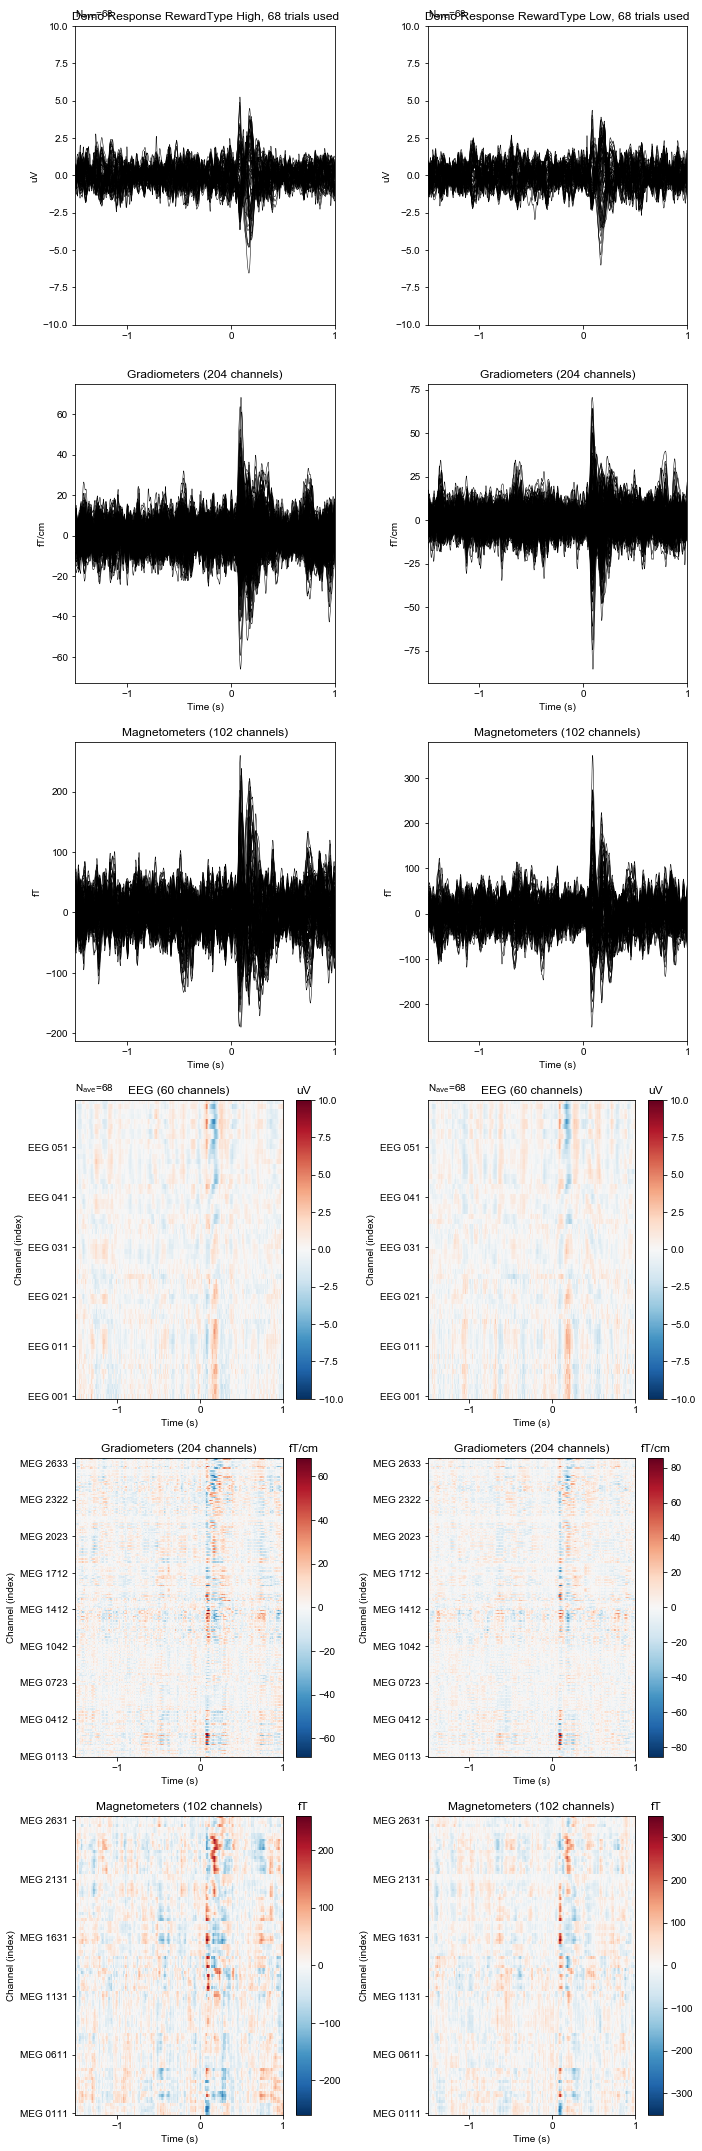

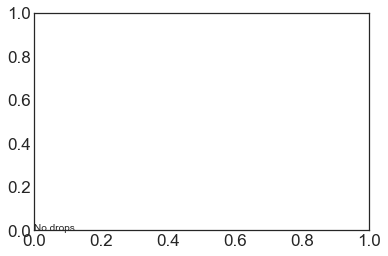

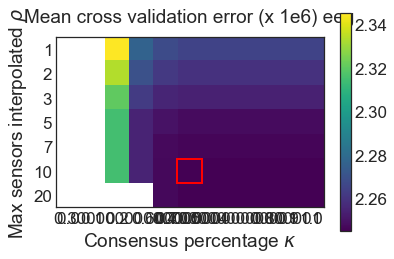

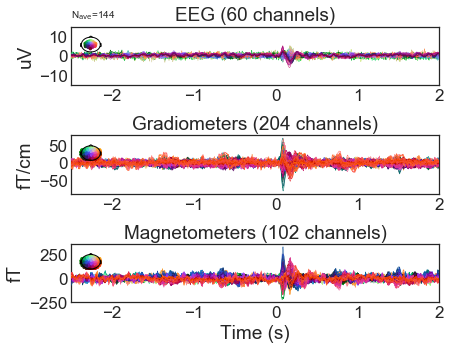

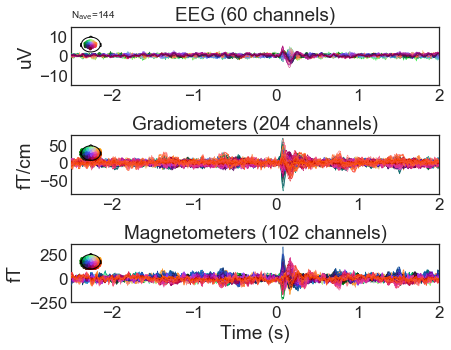

In [6]:
from MEEGbuddy import loadMEEGbuddies
import os.path as op
import os

data = loadMEEGbuddies(op.join(os.getcwd(),'data'))[0]

event = 'Cue'
condition = 'Stimulus Type'
data.filterEpochs(event,h_freq=40,l_freq=None,keyword_in='Autoreject',keyword_out='Autoreject_Filtered')
data.filterEpochs('Baseline',h_freq=40,l_freq=None,keyword_in='Autoreject',keyword_out='Autoreject_Filtered')
data.plotEvoked(event,condition=condition,ylim={'eeg':[-10,10]},keyword='Autoreject_Filtered',downsample=False )
data.plotAutoReject(event,keyword_out='Autoreject')

## Transform to Source Space
To transform to source space we need to average epochs, so we'll pick response and rewardtype to average by
Note: if you want to do source space separately for MEG and EEG, the way that is supported is to make separate MEEGbuddy objects for both modalities:
raw = Raw(fname,preload=True); raw_meg = raw.copy().pick_types(meg=True,eeg=False,eog=True,ecg=True,stim=True); raw_meg.save(fname_meg); raw_eeg = raw.copy().pick_types(meg=False,eeg=True,eog=True,ecg=True,stim=True); raw_eeg.save(fname_eeg);

In [10]:
from MEEGbuddy import loadMEEGbuddies
import os.path as op
import os

data = loadMEEGbuddies(op.join(os.getcwd(),'data'))[0]

event = 'Cue'
condition = 'Stimulus Type'
data.epochs2source(event,condition,keyword_in='Autoreject')
data.epochs2source(event,condition,keyword_in='Autoreject_Filtered')

Response epochs loaded for autoreject
Baseline epochs loaded for autoreject
Making forward model...
Making inverse for High...
Saving inverse for Response RewardType High
Applying inverse on baseline for High...
Saving source for Baseline RewardType High
Applying inverse for High
Saving source for Response RewardType High
Making inverse for Low...
Saving inverse for Response RewardType Low
Applying inverse on baseline for Low...
Saving source for Baseline RewardType Low
Applying inverse for Low
Saving source for Response RewardType Low


## Time Frequency Decomposition

In [ ]:
from MEEGbuddy import loadMEEGbuddies
import os.path as op
import os

data = loadMEEGbuddies(op.join(os.getcwd(),'data'))[0]

event = 'Cue'
condition = 'Stimulus Type'
data.makeWavelets(event,condition)

# Visualizations

## Plot Source Space
Nota bene: while this is running, it's okay to put other windows in front of the mayavi window but if you minize the mayavi window the images will be of your desktop :) 

PS: You're going to want to leave this to run overnight

Response epochs loaded for autoreject
Combining gifs for High


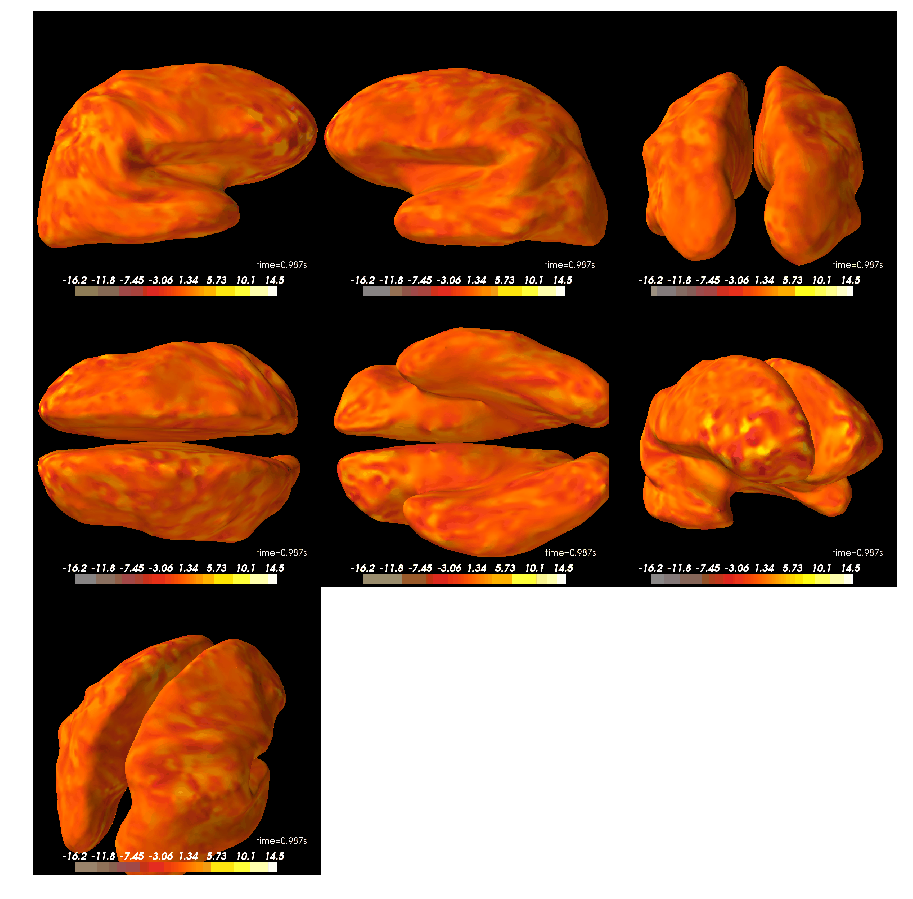

In [ ]:
%matplotlib inline
from MEEGbuddy import loadMEEGbuddies
import os.path as op
import os

data = loadMEEGbuddies(op.join(os.getcwd(),'data'))[0]

event = 'Cue'
condition = 'Stimulus Type'
data.plotSourceSpace('Cue','Stimulus Type',keyword='Autoreject')
data.plotSourceSpace('Cue','Stimulus Type',keyword='Autoreject_Filtered')

## Topoplot

In [ ]:
from MEEGbuddy import loadMEEGbuddies
import os.path as op
import os

data = loadMEEGbuddies(op.join(os.getcwd(),'data'))[0]

event = 'Cue'
condition = 'Stimulus Type'
data.plotTopo(event,condition=condition,keyword='Autoreject_Filtered',
              show=True,detrend=1,downsample=False)

## Channel Plot

In [ ]:
from MEEGbuddy import loadMEEGbuddies
import os.path as op
import os

data = loadMEEGbuddies(op.join(os.getcwd(),'data'))[0]

event = 'Cue'
condition = 'Stimulus Type'
data.channelPlot(event,condition,keyword='Autoreject_Filtered')

## Multitaper Spectrogram (for determining sleep)
As to be expected, the partipant in this example was awake and so their spectrogram shows no signs of sleep as described at sleepeeg.org (thanks to Mike Prerau!). If they were asleep you could use the GUI to drag boxes around the areas of wake and sleep which would then be saved out in the behavior (under "State" as default as in condition='State',values=['Sleep','Wake','Neither'] but these labels can be changedt too)

In [ ]:
from MEEGbuddy import loadMEEGbuddies
import os.path as op
import os

data = loadMEEGbuddies(op.join(os.getcwd(),'data'))[0]

event = 'Cue'
condition = 'Stimulus Type'
data.psdMultitaper(keyword='Preprocessed',ch='EEG 059') #typically Oz is used and I think this is Oz in this dataset

## Control Variables
Most will usually not be that useful but some are really good out of the box!

In [ ]:
from MEEGbuddy import loadMEEGbuddies
import os.path as op
import os

data = loadMEEGbuddies(op.join(os.getcwd(),'data'))[0]

event = 'Cue'
condition = 'Stimulus Type'
data.plotControlVariables()

# Analyses

## Cluster Permutation Test

## Time Frequency Decompostion